In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

# Native libraries
import os
import math


import warnings
warnings.filterwarnings('ignore')

In [2]:
def column_processing(_dataframe):
    _dataframe = _dataframe.drop(['Unnamed: 0','first','last','gender','lat','long',
                                  'city_pop','job','dob','unix_time','merch_lat','merch_long',
                                  'street','city','state','zip','trans_num','merchant'                      
                                  ],axis= True)
    
    _dataframe['trans_date_trans_time'] = pd.to_datetime(_dataframe['trans_date_trans_time'])

    _dataframe['day_of_week'] = _dataframe['trans_date_trans_time'].dt.dayofweek
    _dataframe['week_of_year'] = _dataframe['trans_date_trans_time'].dt.isocalendar()['week']
    _dataframe['hour_of_day'] = _dataframe['trans_date_trans_time'].dt.hour
    _dataframe['month_of_year'] = _dataframe['trans_date_trans_time'].dt.month
    _dataframe['quarter_of_year'] = _dataframe['trans_date_trans_time'].dt.quarter
    _dataframe['minute_of_hour'] = _dataframe['trans_date_trans_time'].dt.minute
    
    
    # Create a new feature to label transactions as weekday (0) or weekend (1)
    _dataframe['is_weekend'] = (_dataframe['day_of_week'] >= 5).astype(int)



    return _dataframe

def create_temporal_columns(_dataframe_o):
    # Convert 'Date' column to datetime format
    _dataframe_o['trans_date_trans_time'] = pd.to_datetime(_dataframe_o['trans_date_trans_time'])

    # Sort the DataFrame by 'Date'
    _dataframe_o = _dataframe_o.sort_values(by=['trans_date_trans_time'])

    cc_num_vector = _dataframe_o['cc_num'].unique()
    
    df_return = pd.DataFrame()

    for cc in cc_num_vector:

        cc_mask = _dataframe_o['cc_num'].isin([cc])
        _dataframe = _dataframe_o[cc_mask].reset_index(drop=True)

        _col_names = ['seconds_between_transaction']#,'seconds_between_transaction_categories']

        for c in _col_names:
            _dataframe[c] = _dataframe['trans_date_trans_time'] - _dataframe['trans_date_trans_time'].shift(1)
            _dataframe[c] = _dataframe[c].dt.total_seconds()
            _dataframe[c] = _dataframe[c].fillna(0)

        for month in _dataframe['month_of_year'].unique():
            for day in _dataframe[_dataframe['month_of_year'] == month]['day_of_week'].unique():
                n = _dataframe[(_dataframe['day_of_week'] == day) & (_dataframe['month_of_year'] == month) ].index[0]
                _dataframe['seconds_between_transaction'].loc[n] = 0

        _dataframe = _dataframe.sort_values(by=['category','trans_date_trans_time'])
        _dataframe = _dataframe.reset_index(drop= True)


        

        #_dataframe['log_seconds_between_transaction_categories'] = np.log( _dataframe['seconds_between_transaction_categories'])
        _dataframe['log_seconds_between_transaction'] = np.log( _dataframe['seconds_between_transaction'])
        _dataframe = _dataframe.fillna(0)
        _dataframe = _dataframe.replace(-np.inf,0)
        _dataframe = _dataframe.replace(np.inf,0)


    _dataframe['day_of_year'] = _dataframe['trans_date_trans_time'].dt.dayofyear

    _dataframe = _dataframe.sort_values(by=['trans_date_trans_time'])
    _dataframe = _dataframe.reset_index(drop= True)
    
    _dataframe['prev_category'] =  _dataframe['category'].shift(1)


    for day in _dataframe['day_of_year'].unique():
        day_condition = _dataframe['day_of_year'] == day

        # Find the index for the first occurrence of the day
        _index = _dataframe.loc[day_condition].index[0]

        # Set values using loc
        _dataframe.loc[_index, 'seconds_between_transaction'] = 0
        _dataframe.loc[_index, 'prev_category'] = 'None'


    df_return = pd.concat([df_return, _dataframe])

        

    return df_return


In [3]:
df=pd.read_csv("Credit_Card/fraudTest.csv")

In [8]:
# Define the initial vector of cc_num values
cc_num_vector = [30270432095985]#,630423337322,6538441737335434]

# Create a boolean mask to filter rows for the specified cc_num values
mask = df['cc_num'].isin(cc_num_vector)

# Create a separate DataFrame for the specified cc_num values
df_dummy = df[mask].reset_index(drop=True)

In [9]:
df_dummy.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,45,2020-06-21 12:29:30,30270432095985,"fraud_Bahringer, Bergnaum and Quitzon",home,3.94,Lisa,Lin,F,908 Brooks Brook,...,40.6761,-91.0391,725,Environmental consultant,1972-11-28,4326b0d0ee56d328d40269e79a68ea30,1371817770,40.922923,-91.977219,0
1,519,2020-06-21 15:09:01,30270432095985,fraud_Macejkovic-Lesch,shopping_pos,3.09,Lisa,Lin,F,908 Brooks Brook,...,40.6761,-91.0391,725,Environmental consultant,1972-11-28,b8565ce8834eb042e86a0263a7dae4f1,1371827341,41.143338,-90.502649,0
2,1220,2020-06-21 19:08:21,30270432095985,fraud_Corwin-Romaguera,travel,73.18,Lisa,Lin,F,908 Brooks Brook,...,40.6761,-91.0391,725,Environmental consultant,1972-11-28,fbab8e786a6f0d93dd0ebed5038da990,1371841701,41.318805,-90.501288,0
3,2525,2020-06-22 04:03:19,30270432095985,fraud_Cassin-Harvey,grocery_net,42.38,Lisa,Lin,F,908 Brooks Brook,...,40.6761,-91.0391,725,Environmental consultant,1972-11-28,98b1afb79c7975fe89ef10f77eae5cd9,1371873799,41.625499,-90.526002,0
4,2731,2020-06-22 05:39:02,30270432095985,fraud_Emard Inc,gas_transport,43.36,Lisa,Lin,F,908 Brooks Brook,...,40.6761,-91.0391,725,Environmental consultant,1972-11-28,caee1ab1944da87190ad00c6f9b191bc,1371879542,40.333947,-91.328809,0


In [10]:
df_dummy = column_processing(df_dummy)

In [11]:
df_dummy_fraud = df_dummy[df_dummy['is_fraud'] == True]
first_fraud_month = df_dummy_fraud['month_of_year'].min()

df_dummy_post_fraud_transactions = df_dummy[df_dummy['month_of_year'] >= first_fraud_month]
df_dummy = df_dummy[df_dummy['month_of_year'] < first_fraud_month]

df_dummy = create_temporal_columns(df_dummy)
df_dummy_post_fraud_transactions = create_temporal_columns(df_dummy_post_fraud_transactions)

In [12]:
df_dummy = df_dummy.sort_values(by=['trans_date_trans_time'])
df_dummy_post_fraud_transactions = df_dummy_post_fraud_transactions.sort_values(by=['trans_date_trans_time'])

In [13]:
df_dummy = df_dummy.sort_values(by=['trans_date_trans_time'])

In [10]:
df_dummy['lg_amt'] = np.log( df_dummy['amt'])

In [11]:
df_dummy['day_of_week'] = df_dummy['day_of_week'].replace(0,7)

array([[<Axes: title={'center': 'lg_amt'}>,
        <Axes: title={'center': 'seconds_between_transaction'}>],
       [<Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'hour_of_day'}>],
       [<Axes: title={'center': 'is_weekend'}>,
        <Axes: title={'center': 'log_seconds_between_transaction'}>]],
      dtype=object)

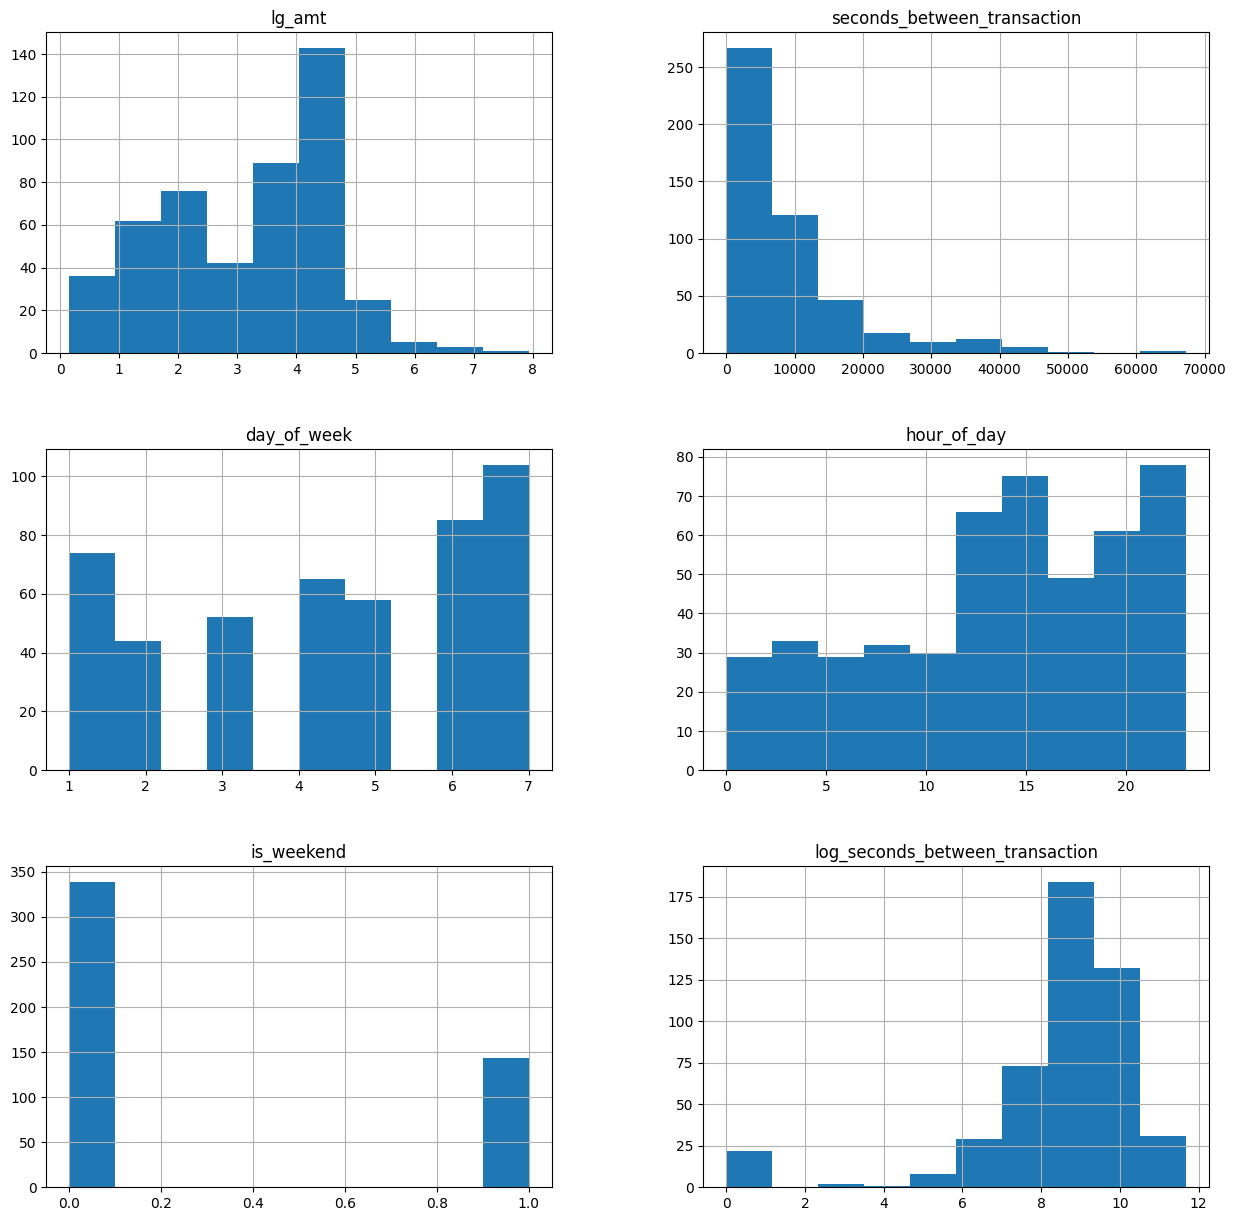

In [12]:
df_dummy[['lg_amt','seconds_between_transaction','day_of_week','hour_of_day','is_weekend','log_seconds_between_transaction']].hist(figsize=(15,15))

In [13]:
df_dummy.sort_values(by=['day_of_week','hour_of_day','minute_of_hour']).head(5)

,trans_date_trans_time,cc_num,category,amt,is_fraud,day_of_week,week_of_year,hour_of_day,month_of_year,quarter_of_year,minute_of_hour,is_weekend,seconds_between_transaction,log_seconds_between_transaction,day_of_year,prev_category,lg_amt
239,2020-07-28 01:12:20,30270432095985,gas_transport,65.01,0,1,31,1,7,3,12,0,0.0,9.490847,210,None,4.174541
283,2020-08-04 01:19:16,30270432095985,gas_transport,52.06,0,1,32,1,8,3,19,0,0.0,0.000000,217,None,3.952397
96,2020-07-07 01:25:41,30270432095985,grocery_pos,65.40,0,1,28,1,7,3,25,0,0.0,0.000000,189,None,4.180522
50,2020-06-30 02:00:14,30270432095985,grocery_pos,84.54,0,1,27,2,6,2,0,0,0.0,9.801455,182,None,4.437225
187,2020-07-21 02:53:53,30270432095985,gas_transport,70.10,0,1,30,2,7,3,53,0,0.0,9.393911,203,None,4.249923


Checking how categorical variables affect time between arrivals

In [14]:
df_distributtion =df_dummy.sort_values(by=['day_of_week','hour_of_day','minute_of_hour'])
df_distributtion = df_distributtion.reset_index(drop=True)
df_distributtion = df_distributtion.reset_index(drop=False)


[]

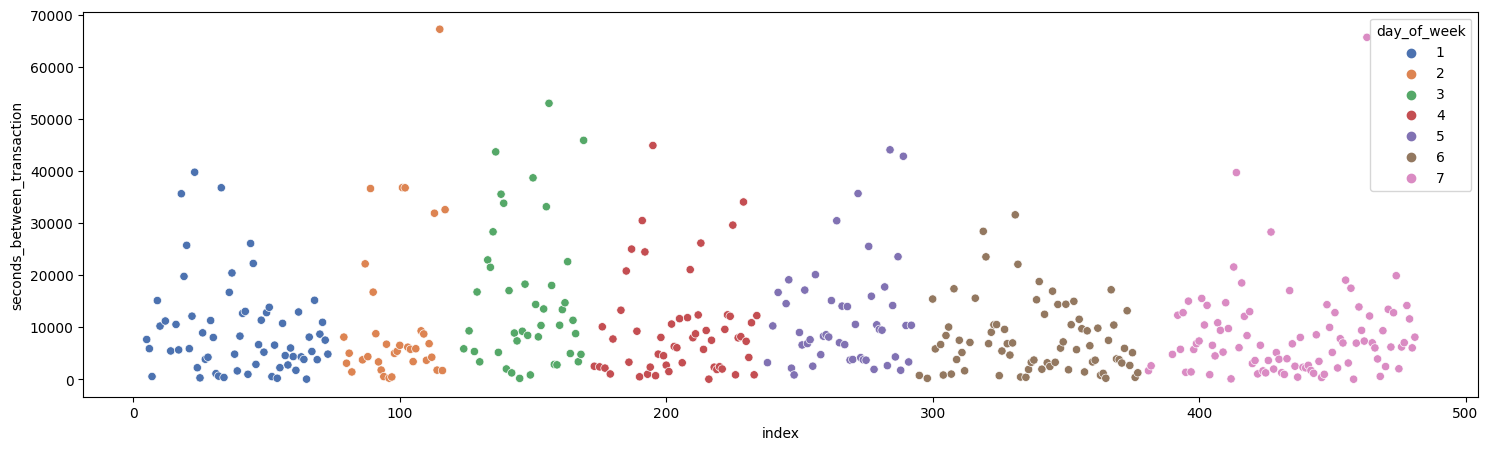

In [76]:
plt.figure(figsize=(18, 5))
sns.scatterplot(data=df_distributtion[df_distributtion['seconds_between_transaction'] != 0], x="index", y="seconds_between_transaction",hue='day_of_week', palette="deep")


plt.vlines(x=46, ymin=0, ymax=10, colors= 'red')
plt.vlines(x=76, ymin=0, ymax=10, colors= 'red')
plt.vlines(x=235, ymin=0, ymax=10, colors= 'red')
plt.vlines(x=337, ymin=0, ymax=10, colors= 'red')
plt.vlines(x=438, ymin=0, ymax=10, colors= 'red')

plt.plot()

Notice that we have different patterns

In [16]:
# si hora es menor a 12 entonces le asigno el 0.5 de lo contrario es solo el dia
df_distributtion['dat_category'] = df_distributtion['day_of_week']
_index = df_distributtion[df_distributtion["hour_of_day"] > 11].index
df_distributtion['dat_category'].loc[_index] = df_distributtion['day_of_week'].loc[_index] + 0.5

[]

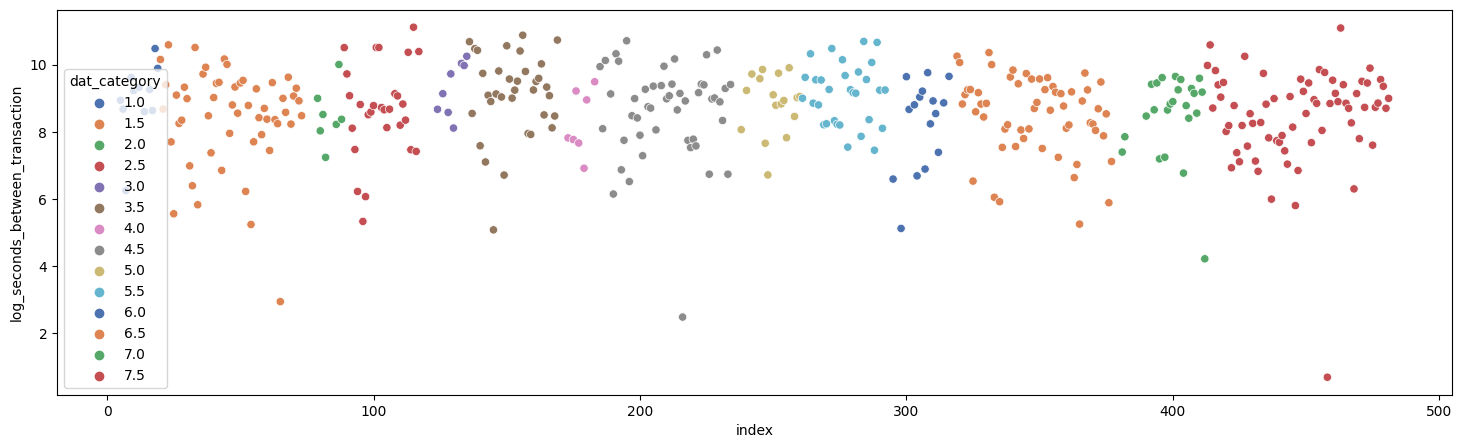

In [17]:
plt.figure(figsize=(18, 5))
sns.scatterplot(data=df_distributtion[df_distributtion['seconds_between_transaction'] != 0], x="index", y="log_seconds_between_transaction",hue='dat_category', palette="deep")
plt.plot()

[]

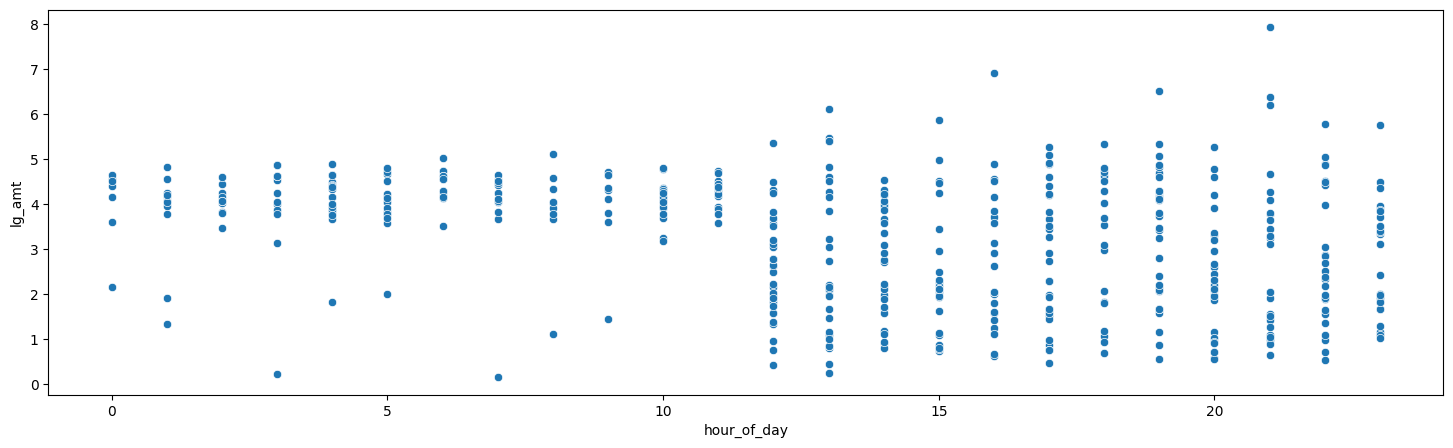

In [18]:
plt.figure(figsize=(18, 5))
sns.scatterplot(data=df_distributtion, x="hour_of_day", y="lg_amt", palette="deep")
plt.plot()

[]

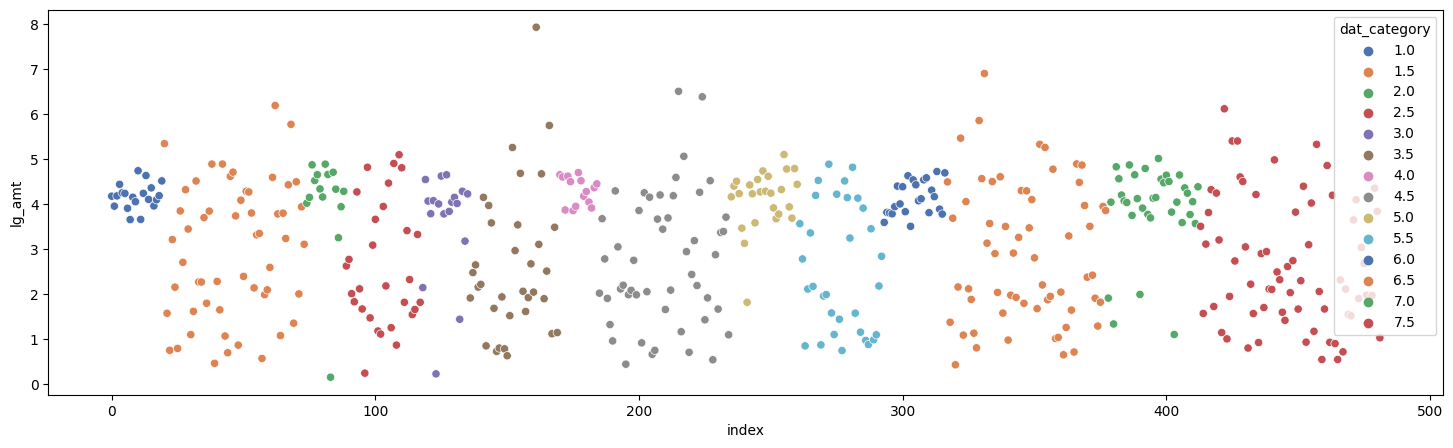

In [19]:
plt.figure(figsize=(18, 5))
sns.scatterplot(data=df_distributtion, x="index", y="lg_amt",hue='dat_category', palette="deep")
plt.plot()

In [47]:
df_distributtion.head()

,index,trans_date_trans_time,cc_num,category,amt,is_fraud,day_of_week,week_of_year,hour_of_day,month_of_year,quarter_of_year,minute_of_hour,is_weekend,seconds_between_transaction,log_seconds_between_transaction,day_of_year,prev_category,lg_amt,dat_category
0,0,2020-07-28 01:12:20,30270432095985,gas_transport,65.01,0,1,31,1,7,3,12,0,0.0,9.490847,210,None,4.174541,1.0
1,1,2020-08-04 01:19:16,30270432095985,gas_transport,52.06,0,1,32,1,8,3,19,0,0.0,0.000000,217,None,3.952397,1.0
2,2,2020-07-07 01:25:41,30270432095985,grocery_pos,65.40,0,1,28,1,7,3,25,0,0.0,0.000000,189,None,4.180522,1.0
3,3,2020-06-30 02:00:14,30270432095985,grocery_pos,84.54,0,1,27,2,6,2,0,0,0.0,9.801455,182,None,4.437225,1.0
4,4,2020-07-21 02:53:53,30270432095985,gas_transport,70.10,0,1,30,2,7,3,53,0,0.0,9.393911,203,None,4.249923,1.0


In [91]:
df_sa = df_distributtion.groupby(['week_of_year','day_of_week'],as_index= False )[['amt']].sum('amt')

In [92]:
df_sa = df_sa.groupby('day_of_week', as_index= False)['amt'].agg(['mean','std'])

In [93]:
df_sa.head(10)

,day_of_week,mean,std
0,1,415.983000,209.250486
1,2,238.878889,164.602116
2,3,486.890000,906.920804
3,4,371.698000,267.859442
4,5,284.402000,131.107668
5,6,482.902727,411.538122
6,7,474.555455,237.558723


<StemContainer object of 3 artists>

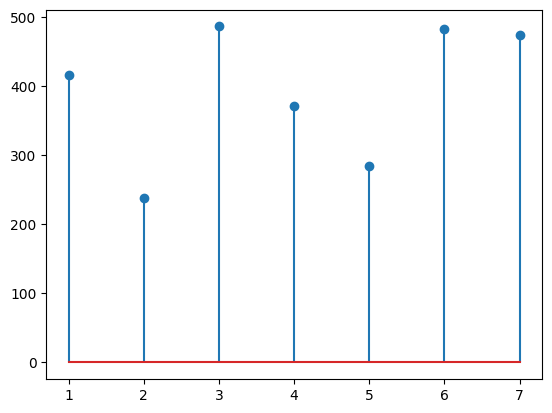

In [94]:
plt.stem(df_sa['day_of_week'], df_sa['mean'])


Ok this make sense i lake what im seeing. The division between max transaction freq and also there is a pattern on how the spent mon

In [170]:
n_bins = len(df_distributtion['dat_category'].unique())
df_distributtion[['dat_category','cc_num']].groupby(by = 'dat_category').count()


,cc_num
dat_category,
1.0,20
1.5,54
2.0,15
2.5,29
3.0,18
3.5,34
4.0,15
4.5,50
5.0,26


In [171]:
df_distributtion = df_distributtion.drop(['is_fraud','index','cc_num','day_of_week','is_weekend','minute_of_hour','week_of_year','quarter_of_year','month_of_year','day_of_year'],axis=True)


In [172]:
df_distributtion.head()

,trans_date_trans_time,category,amt,hour_of_day,seconds_between_transaction,log_seconds_between_transaction,prev_category,lg_amt,dat_category
0,2020-06-21 12:29:30,home,3.94,12,0.0,0.000000,None,1.371181,6.5
1,2020-06-21 15:09:01,shopping_pos,3.09,15,9571.0,9.166493,home,1.128171,6.5
2,2020-06-21 19:08:21,travel,73.18,19,14360.0,9.572202,shopping_pos,4.292922,6.5
3,2020-06-22 04:03:19,grocery_net,42.38,4,0.0,0.000000,None,3.746677,7.0
4,2020-06-22 05:39:02,gas_transport,43.36,5,5743.0,8.655737,grocery_net,3.769537,7.0


Matrix of transition for each dat_category

Matrix (prev_category -> category) for each dat_category 

In [101]:
from scipy.stats import norm, expon, gamma, beta
from scipy.stats import anderson_ksamp

In [332]:

# Assuming df_distribution is your DataFrame with the mentioned columns

# Define candidate distributions
distributions = {
    'norm': norm,
    'exponential': expon,
    'gamma': gamma,
    'beta': beta
}

# Function to fit a distribution and return the Anderson-Darling statistic
def fit_distribution(data, distribution):
    params = distribution.fit(data)
    ad_statistic = anderson_ksamp([data, distribution(*params).rvs(len(data))])[0]
    return ad_statistic, params

# Initialize a dictionary to store the best-fitting distribution and parameters
best_distributions = {}

# Iterate through each dat_category
for dat_category in df_distributtion['dat_category'].unique():
    df_dat_category = df_distributtion[df_distributtion['dat_category'] == dat_category]

    # Iterate through unique pairs of prev_category and category
    for pair in df_dat_category[['prev_category', 'category']].drop_duplicates().itertuples(index=False):
        prev_category, category = pair

        # Extract relevant data for the pair
        data = df_dat_category[(df_dat_category['prev_category'] == prev_category) & (df_dat_category['category'] == category)]['log_seconds_between_transaction']

        # Initialize variables to track the best-fitting distribution
        best_distribution = None
        best_params = None
        best_ad_statistic = np.inf  # Initialize with a high value

        # Iterate through candidate distributions
        for distribution_name, distribution in distributions.items():
            try:
                ad_statistic, params = fit_distribution(data, distribution)
                
                # Update if the current distribution is a better fit
                if ad_statistic < best_ad_statistic:
                    best_distribution = distribution_name
                    best_params = params
                    best_ad_statistic = ad_statistic

            except Exception as e:
                # Handle distribution fitting errors
                print(f"Error fitting {distribution_name} distribution for {dat_category}, {prev_category} to {category}: {e}")

        # Store the best-fitting distribution and parameters
        best_distributions[(dat_category, prev_category, category)] = (best_distribution, best_params)

# Display or further process the best-fitting distributions and parameters
for key, (distribution, params) in best_distributions.items():
    print(f"For {key}, best distribution: {distribution}, parameters: {params}")


Error fitting norm distribution for 1.0, None to gas_transport: anderson_ksamp needs more than one distinct observation
Error fitting exponential distribution for 1.0, None to gas_transport: anderson_ksamp needs more than one distinct observation
Error fitting gamma distribution for 1.0, None to gas_transport: Optimization converged to parameters that are outside the range allowed by the distribution.
Error fitting norm distribution for 1.0, None to grocery_pos: anderson_ksamp needs more than one distinct observation
Error fitting exponential distribution for 1.0, None to grocery_pos: anderson_ksamp needs more than one distinct observation
Error fitting gamma distribution for 1.0, None to grocery_pos: Optimization converged to parameters that are outside the range allowed by the distribution.
Error fitting beta distribution for 1.0, None to grocery_pos: index -1 is out of bounds for axis 0 with size 0
Error fitting norm distribution for 1.0, None to grocery_net: anderson_ksamp needs mo

In [338]:
best_distributions[1,'None', 'gas_transport']

('beta',
 (0.9899920243471434,
  1.0393951944685846,
  -2.661587125184533e-26,
  9.609767701594333e-26))

Probability of first transaction

In [340]:
df_distributtion.columns

Index(['trans_date_trans_time', 'category', 'amt', 'hour_of_day',
       'seconds_between_transaction', 'prev_category', 'lg_amt',
       'dat_category'],
      dtype='object')

In [375]:
# Filter the DataFrame to include only rows where seconds_between_transaction is 0
df_zero_seconds = df_distributtion[df_distributtion['seconds_between_transaction'] == 0]

# Calculate the total count of occurrences for each unique pair of prev_category and category
total_counts = df_zero_seconds.groupby([ 'category']).size().reset_index(name='total_count')

# Calculate the probability values for each pair
total_counts['probability'] = total_counts['total_count'] / total_counts['total_count'].sum()

# Display or further process the result
print(total_counts)

        category  total_count  probability
0  entertainment           22     0.258824
1    food_dining           13     0.152941
2  gas_transport           26     0.305882
3    grocery_net            4     0.047059
4    grocery_pos           10     0.117647
5           home            3     0.035294
6      kids_pets            2     0.023529
7       misc_net            4     0.047059
8   shopping_pos            1     0.011765


Now i have 

total_counts -> Initial probability 
best_distributions -> Tells me the transition probability by day

In [173]:
import networkx as nx

In [179]:
df_s = df_distributtion[
    (df_distributtion['dat_category'] == 1.5) | 
    (df_distributtion['dat_category'] == 2.5) |  
    (df_distributtion['dat_category'] == 3.5) | 
    (df_distributtion['dat_category'] == 4.5) |  
    (df_distributtion['dat_category'] == 5.5) | 
    (df_distributtion['dat_category'] == 6.5) | 
    (df_distributtion['dat_category'] == 7.5) 
]

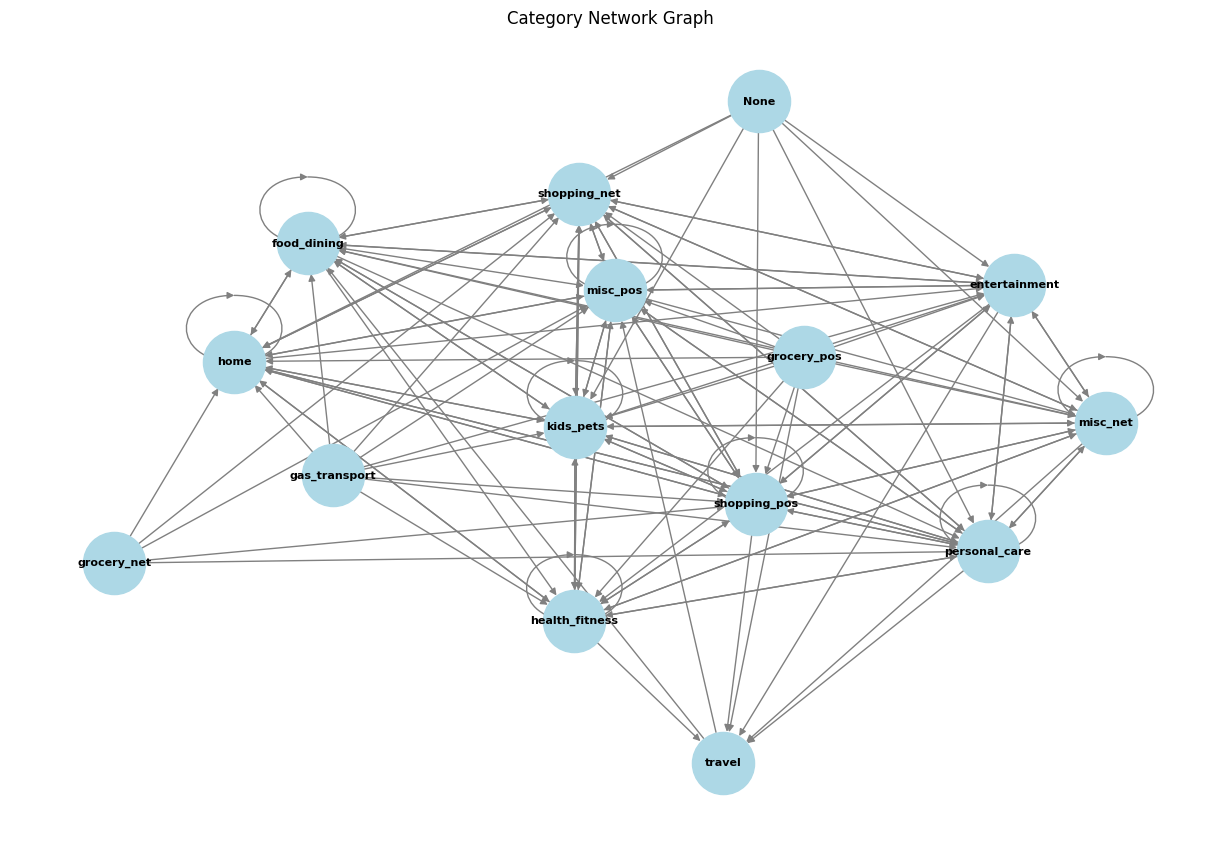

In [175]:
# Create a directed graph
G = nx.from_pandas_edgelist(df_s, 'prev_category', 'category', ['amt'], create_using=nx.DiGraph())

# Plot the network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # You can use other layout options as well
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='lightblue', node_size=2000, font_size=8, edge_color='gray')
plt.title('Category Network Graph')
plt.show()


In [176]:
df_s = df_distributtion[
    (df_distributtion['dat_category'] == 1) | 
    (df_distributtion['dat_category'] == 2) |  
    (df_distributtion['dat_category'] == 3) | 
    (df_distributtion['dat_category'] == 4) |  
    (df_distributtion['dat_category'] == 5) | 
    (df_distributtion['dat_category'] == 6) | 
    (df_distributtion['dat_category'] == 7) 
]

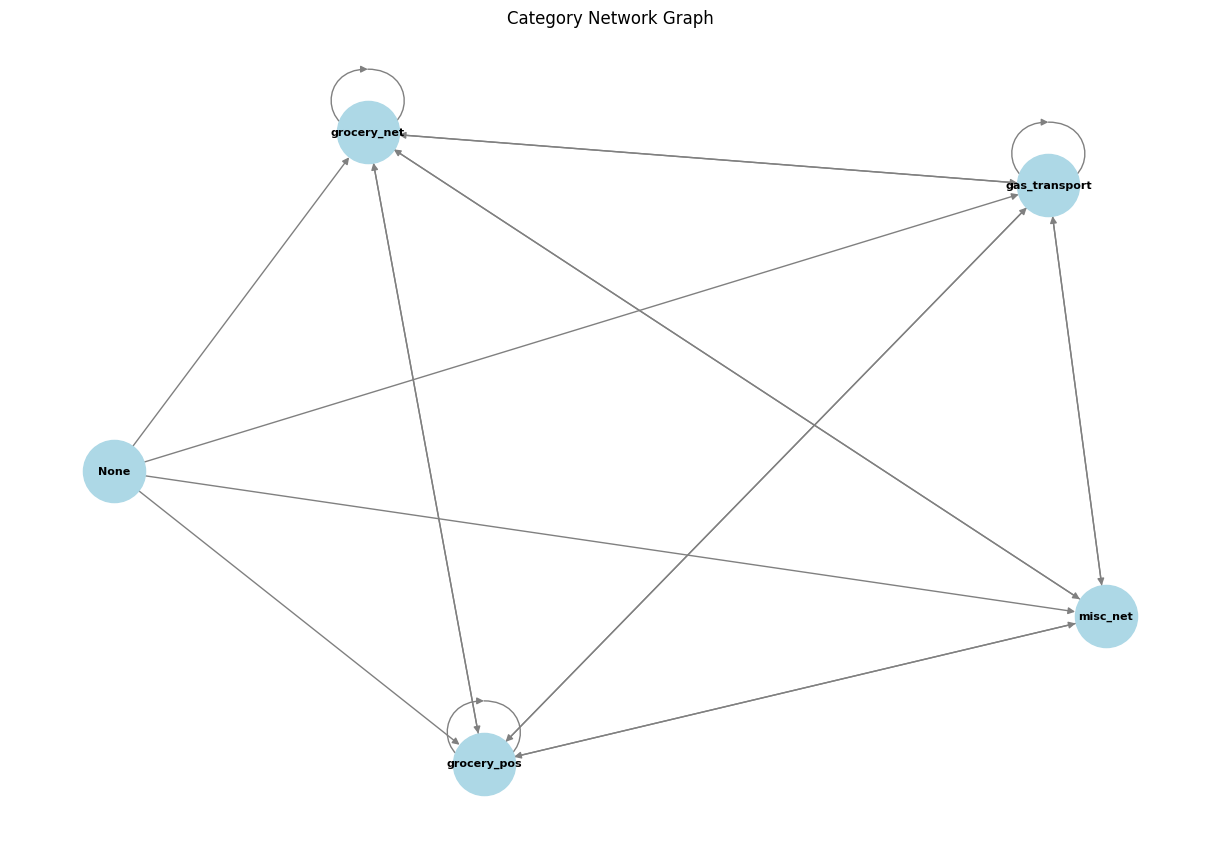

In [177]:
# Create a directed graph
G = nx.from_pandas_edgelist(df_s, 'prev_category', 'category', ['amt'], create_using=nx.DiGraph())

# Plot the network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # You can use other layout options as well
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='lightblue', node_size=2000, font_size=8, edge_color='gray')
plt.title('Category Network Graph')
plt.show()
